# RQ1 - Output Analysis

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import string
import re
from gensim.models import Word2Vec

Now we try to evaluate and understand the performance of the search engine:

a) Choose 10 queries to run. How to choose the queries? The selection of the queries is up to you. It’s strongly suggested to select terms based on the popularity (keywords ranked by term frequencies or by tf-idf, etc…)

** To help us decide which queries could be more interesting to check, we used the WorldCloud function to generate a map of words that according to size, are more relevant to the topic: **

In [2]:
data = pd.read_csv("df_tweets.csv", index_col=0)
data.shape

(24788, 35)

In [3]:
data['clean_tweet'] = data['clean_tweet'].astype(str)

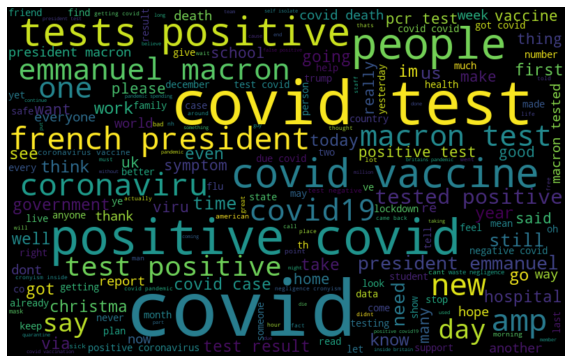

In [4]:
# could be useful to determine the queries
all_words = ' '.join([text for text in data['clean_tweet']]) 

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

** The 10 queries we decided to run based on the WordCloud, which could be the most interesting ones, are: **
- positive covid
- covid vaccine
- test
- covid december
- pcr test
- info nct
- vaccine virus
- hospitals test
- trump covid
- covid test

b) Return a top-20 list of documents for each of the 10 queries, using tf-idf + cosine similarity methods.

In [5]:
def create_index_tfidf(lines, numDocuments):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of Wikipedia articles
    numDocuments -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """
        
    index=defaultdict(list)
    tf=defaultdict(list) #term frequencies of terms in documents (documents in the same order as in the main index)
    df=defaultdict(int)         #document frequencies of terms in the corpus
    titleIndex=defaultdict(str)
    idf=defaultdict(float)
    id_ = 0
    for line in lines:
        terms = line.split('|')
        terms = terms[0].split()
        page_id = id_         
        titleIndex[page_id] = line      
        
        termdictPage={}

        for position, term in enumerate(terms): ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in python)
        
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm=0
        for term, posting in termdictPage.items(): 
            # posting is a list containing doc_id and the list of positions for current term in current document: 
            # posting ==> [currentdoc, [list of positions]] 
            # you can use it to inferr the frequency of current term.
            norm+=len(posting[1])**2 
        norm=math.sqrt(norm)


        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4))  ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1  # increment df for current term
        
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
        # Compute idf following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(numDocuments/df[term])),4)
        
        id_ += 1
        #print(id_)
    return index, tf, df, idf, titleIndex

In [6]:
tweet = data['print_info'].to_numpy()

In [7]:
numDocuments = len(tweet[:1000])
index, tf, df, idf, titleIndex = create_index_tfidf(tweet[:1000], numDocuments)

In [8]:
def rankDocuments(terms, docs, index, idf, tf, titleIndex):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors=defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector=[0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    # HINT: use when computing tf for queryVector
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex]=query_terms_count[term]/query_norm * idf[term] 

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            
            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                docVectors[doc][termIndex]=tf[term][docIndex] * idf[term]  # TODO: check if multiply for idf

    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, run again") 
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [9]:
def search_tf_idf(query, index):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=query.split()
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf, titleIndex)   
    return ranked_docs

In [10]:
print("Insert your query:\n")
query = input()
query = query.lower()
ranked_docs = search_tf_idf(query, index)    
top = 20

#create a dataframe to store the results in a tsv file
df = pd.DataFrame(columns=['Page_ID', 'Tweet'])
page_id = []
tw = []

print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top] :
    print("tweet_id= {} - tweet: {}".format(d_id, titleIndex[d_id]))
    page_id.append(d_id)
    tw.append(titleIndex[d_id])
    
df['Page_ID'] = page_id
df['Tweet'] = tw
#df.to_csv('top20_tfidf_RQ1_10.tsv', sep = '\t')

Insert your query:

covid

Top 20 results out of 525 for the seached query:

tweet_id= 445 - tweet: puto covid|ceeciliarg|Thu Dec 17 11:20:22 +0000 2020||0|0|
tweet_id= 279 - tweet: covid risk|Crashmadness|Thu Dec 17 11:21:07 +0000 2020||0|0|
tweet_id= 240 - tweet: long covid|jpfallon27|Thu Dec 17 11:21:15 +0000 2020||0|0|https://t.co/spdqfgCtSV
tweet_id= 960 - tweet: realdonaldtrump are properly diagnosed covid or died causes blamed covid|Victori10859973|Thu Dec 17 11:18:09 +0000 2020||0|0|
tweet_id= 910 - tweet: covid restrictions think|oofchae|Thu Dec 17 11:18:21 +0000 2020||1|0|
tweet_id= 811 - tweet: covid domino effect|PieroCastellano|Thu Dec 17 11:18:49 +0000 2020||1|0|https://t.co/0jXjrsPhAt
tweet_id= 784 - tweet: will world covid|alexcampos650|Thu Dec 17 11:18:57 +0000 2020||0|0|
tweet_id= 649 - tweet: normalize catching covid|sexcjoonie|Thu Dec 17 11:19:31 +0000 2020||1|0|
tweet_id= 447 - tweet: macron got covid|sarpanderus|Thu Dec 17 11:20:21 +0000 2020||0|0|
tweet_id= 380 -

c) Return a top-20 list of documents for each of the 10 queries, using word2vec + cosine similarity.

In [12]:
%%time

#we split each tweet to separate it into works
tokenized_tweet = data['clean_tweet'].apply(lambda x: x.split()) # tokenizing 

# we pass the tokens and create the Word2Vec Model
model = Word2Vec(tokenized_tweet, size=500, window=10, min_count=8, sg = 1, hs = 0, negative = 15, workers= 32, seed = 34) 

# we check similaritys score with some words
word_sim = model.most_similar('vaccine')

print('Most similar words to vaccine: ' + str(word_sim))

Most similar words to vaccine: [('vaccines', 0.854162335395813), ('pfizer', 0.7578389644622803), ('vaccinated', 0.7461851239204407), ('extra', 0.7446262836456299), ('panel', 0.7379982471466064), ('doses', 0.7378169894218445), ('vials', 0.7333449721336365), ('receive', 0.727229654788971), ('vaccination', 0.725184440612793), ('moderna', 0.719294548034668)]
CPU times: user 45.4 s, sys: 517 ms, total: 45.9 s
Wall time: 22.1 s


/Users/dianatyman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


In [13]:
# returning vector reperesentation of a tweet from word2vec
def get_embedding_w2v(doc_tokens):
    embeddings = []
    if len(doc_tokens)<1:
        return np.zeros(500)
    else:
        for tok in doc_tokens:
            if tok in model.wv.vocab:
                embeddings.append(model.wv.word_vec(tok))
            else:
                embeddings.append(np.random.rand(500))
        # mean the vectors of individual words to get the vector of the document
        return np.mean(embeddings, axis=0)

# getting Word2Vec Vectors for testing corpus and queries
data['average_w2v'] = data['clean_tweet'].apply(lambda x :get_embedding_w2v(x.split()))
data.head(3)

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,quoted_status_id_str,quoted_status,extended_entities,retweeted_status,clean_tweet,user_name,hashtags,url,print_info,average_w2v
0,Thu Dec 17 11:22:17 +0000 2020,1339531356716609543,1339531356716609543,"@AntarcticGlacie @johnredwood by ""economists a...",True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.339477e+18,1.339477e+18,...,NaN,NaN,NaN,NaN,johnredwood economists agree good growth econo...,SixChipTwat,NaN,https://t.co/cJwfMk71i6,johnredwood economists agree good growth econo...,"[0.0035013000429654126, 0.1453897356488567, 0...."
1,Thu Dec 17 11:22:17 +0000 2020,1339531355844202497,1339531355844202497,@annaturley @colinth7 @johnestevens Seems like...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.339321e+18,1.339321e+18,...,NaN,NaN,NaN,NaN,colinth7 seems like set pretty good example me...,onebritishguy,NaN,https://t.co/HTqpWcFZQf,colinth7 seems like set pretty good example me...,"[0.0066004020277331136, 0.03509579060819408, 0..."
2,Thu Dec 17 11:22:16 +0000 2020,1339531352631349248,1339531352631349248,Heads of government who have had #COVID19 \n\n...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,NaN,NaN,NaN,NaN,heads government covid19 johnson bolsonaro luk...,RossFootball,COVID19,https://t.co/wX7LUURIk6,heads government covid19 johnson bolsonaro luk...,"[0.20569679831283724, 0.22500055075751996, 0.1..."


In [14]:
# now we create the index for the Word2Vec ranking
def create_index_w2v(data):
    """
    Impleent the inverted index
    
    Argument:
    tweets -- collection of tweets
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    """
    index=defaultdict(list) 
    titleIndex = {} # dictionary to map page titles to page ids
         
    
    for id_,line in enumerate(data.clean_tweet):
        terms = line.split('|')
        terms = terms[0].split()
        page_id = id_         
        titleIndex[page_id] = data['print_info'][id_]        
        termdictPage={}

        for position, term in enumerate(terms): ## terms contains page_title + page_text
            try:
                # if the term is already in the dict append the position to the corrisponding list
                termdictPage[term][1].append(position) 
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in python)
        
        #merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage)
            
        
    return index, titleIndex

In [15]:
index, titleIndex = create_index_w2v(data)

In [16]:
def rankDocuments_w2v(terms, docs, index, titleIndex, data, model):
    """
    Perform the ranking of the results of a search based on the our weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    titleIndex -- mapping between page id and page title
    model -- Word2Vector model
    
    Returns:
    Print the list of ranked documents
    """
    docVectors=defaultdict(lambda: [0]*len(terms))    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    queryVector = np.asarray(get_embedding_w2v(terms))

    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    

        # Generate docVectors for matching docs
        for docIndex, (doc, postings) in enumerate(index[term]):
            # Example of [docIndex, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....
            
            if doc in docs:
                docVectors[doc]=np.array(data['average_w2v'][doc])
                
    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine siilarity
    # see np.dot
    docScores=[ [np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items() ]
    docScores.sort(reverse=True)
    resultDocs=[x[1] for x in docScores]
    #print document titles instead if document id's
    #resultDocs=[ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_w2t(query, index, titleIndex, data, model) 
    #print ('\n'.join(resultDocs), '\n')
    return resultDocs

In [17]:
def search_w2t(query, index, titleIndex, data, model):
    '''
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    '''
    query=query.split()
    docs=set()
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs=[posting[0] for posting in index[term]]
            
            # docs = docs Union termDocs
            docs |= set(termDocs)
        except:
            #term is not in index
            pass
    docs=list(docs)
    ranked_docs = rankDocuments_w2v(query, docs, index, titleIndex, data, model)   
    return ranked_docs

In [18]:
print("Insert your query:\n")
query = input()
query = query.lower()
ranked_docs = search_w2t(query, index, titleIndex, data, model)    
top = 20

#create a dataframe to store the results in a tsv file
df_w2v = pd.DataFrame(columns=['Page_ID', 'Tweet'])
page_id_w2v = []
tw_w2v = []

print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top] :
    print("page_id= {} - page_title: {}".format(d_id, titleIndex[d_id]))
    page_id_w2v.append(d_id)
    tw_w2v.append(titleIndex[d_id])
    
df_w2v['Page_ID'] = page_id_w2v
df_w2v['Tweet'] = tw_w2v
#df_w2v.to_csv('top20_w2v_RQ1_10.tsv', sep = '\t')

Insert your query:

covid vaccine

Top 20 results out of 14015 for the seached query:

page_id= 13208 - page_title: covid vaccine|chaerfilm|Thu Dec 17 10:26:52 +0000 2020||0|0|
page_id= 9787 - page_title: ian mckellen covid|Mark_Ma77|Thu Dec 17 10:41:45 +0000 2020||0|0|https://t.co/ZacMpZiwh9
page_id= 17805 - page_title: alaska woman allergic reaction vaccine|HealthcareGlob1|Thu Dec 17 10:07:33 +0000 2020||0|0|https://t.co/ebCDmCpZgB
page_id= 9709 - page_title: sir ian mckellen euphoric receive covid 19 vaccine|Engekiman|Thu Dec 17 10:42:06 +0000 2020||0|0|https://t.co/amSdwvsxTx
page_id= 8756 - page_title: sir ian mckellen euphoric receive covid 19 vaccine|listentopure|Thu Dec 17 10:46:10 +0000 2020||0|0|https://t.co/IKbLwOaauf
page_id= 1020 - page_title: sir ian mckellen euphoric receive covid 19 vaccine|LindaLindae9|Thu Dec 17 11:17:53 +0000 2020||0|0|https://t.co/eK375Na1Bt
page_id= 13512 - page_title: sir ian mckellen covid|ryanogs|Thu Dec 17 10:25:28 +0000 2020||0|0|https://t.co/

e) Choose one vector representation, tf-idf or word2vec, and represent the tweets in a two dimensional scatter plot through the t-sne algorithm. To do so, you may need first to represent the word as a vector, and then the tweet, i.e., resulted as the average value over the words involved. Any other option rather than t-sne may be used, but needs to be justified.

In [38]:
#keys = model.wv.vocab.keys()

In [19]:
keys = ['trump', 'hospitals', 'test']  #some keywords
embedding_clusters = []
word_clusters = []

for termIndex, term in enumerate(keys):
    embeddings = []
    tweets= []
    similar = search_w2t(term, index, titleIndex, data, model)
    a=len(similar)
    print(a)
    for d_id in similar[:118]:
        similar = titleIndex[d_id]
        embeddings.append(np.array(data['average_w2v'][d_id]))
        tweets.append(similar)
    embedding_clusters.append(embeddings)
    word_clusters.append(tweets)

336
118
5018


In [20]:
embedding_clusters = np.array(embedding_clusters)
embedding_clusters.shape

(3, 118, 500)

In [21]:
from sklearn.manifold import TSNE

In [22]:
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


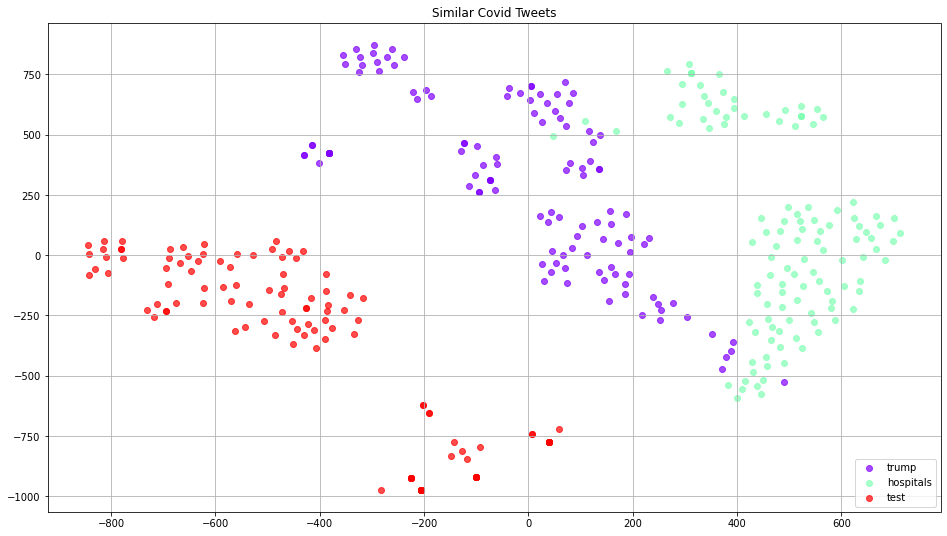

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        '''for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)'''
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar Covid Tweets', keys, embeddings_en_2d, word_clusters, 0.7,
                        'tsne_plot.png')

5 most relevant keywords for each cluster:

In [76]:
# for trump
model.most_similar('trump', topn = 5)

/Users/dianatyman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('election', 0.8809430599212646),
 ('donald', 0.8615451455116272),
 ('administration', 0.8482714891433716),
 ('emails', 0.8429608345031738),
 ('herd', 0.840883731842041)]

In [77]:
# for hospitals
model.most_similar('hospitals', topn = 5)

/Users/dianatyman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('push', 0.9323476552963257),
 ('limit', 0.9057594537734985),
 ('hospitalized', 0.8932732343673706),
 ('patients', 0.8762091994285583),
 ('80', 0.8631941080093384)]

In [78]:
# for test
model.most_similar('test', topn = 5)

/Users/dianatyman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('tes', 0.7437297105789185),
 ('result', 0.7433920502662659),
 ('flow', 0.7336437702178955),
 ('kroger', 0.7291268110275269),
 ('lateral', 0.7187906503677368)]